In [1]:
from collections import Counter
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)

In [2]:
import xgboost as xgb

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [4]:
from statistic import Statistic
from utils import UtilsKy
from analyzer import HelperAnalyzer, AnalyzerPrediction
from decomposition_pca.encode_strategy import Encode

In [5]:
# for autoreload modules
%load_ext autoreload
%autoreload 2

In [6]:
# kyw3
path_data = '/mnt/files/workdata/work/merchants/merchant_33_kyw3_2020-06-05/04_experiments/ex_01_some_teach/'
db_teach = pd.read_csv(UtilsKy.DB_TEACH_KYW3, dtype=str, encoding='cp1251')
db_test = pd.read_csv(UtilsKy.DB_TEST_KYW3, dtype=str, encoding='cp1251')
white = pd.read_csv(UtilsKy.WHITE_KYW3 , dtype=str)

In [7]:
db_teach.columns

Index(['amount', 'amount_deviation', 'bank_currency', 'bin', 'city',
       'count_months_to_end_card', 'day_of_week', 'gender2', 'hour', 'id',
       'is_city_resolved', 'is_gender_undefined', 'latitude', 'longitude',
       'order_id', 'phone_2_norm', 'status'],
      dtype='object')

In [8]:
Statistic.get_table_value_counts(db_teach, 'status')

0    427164
1      6261
Name: status, dtype: int64

In [9]:
Statistic.get_table_value_counts(db_test, 'status')

0    58107
1      755
Name: status, dtype: int64

In [10]:
COL_FACTORS = ['bin', 'amount', 'bank_currency', 'hour', 'day_of_week', 'longitude', 'latitude', 'phone_2_norm'] 
COL_FACTORS = COL_FACTORS + ['is_gender_undefined', 'is_city_resolved']

In [11]:
# For Xgboost
from helper import DataHelper
datahelper = DataHelper(db_teach, db_test, COL_FACTORS)
datahelper.create_train_test()
datahelper.show_columns_with_na()
mean_values = datahelper.get_mean_value()
replaced_values = { col: mean_values[col] for col in ('latitude', 'longitude')}
replaced_values['default'] =  -999
datahelper.replaced_na_values(replaced_values)   
train , test = datahelper.get_train_test()

train na columns : Index(['latitude', 'longitude'], dtype='object')
test na columns : Index(['latitude', 'longitude'], dtype='object')
-999
-999
-999
-999
-999
-999
-999
36.90237577890762
-92.53325861542274
-999


In [12]:
train = train.values
test = test.values
label = db_teach.status

In [13]:
analyzer_prediction =  AnalyzerPrediction(db_teach, db_test, white)

In [16]:
result_df_amount = None
weight = analyzer_prediction.get_xgb_weight()

In [17]:
# Kyw3
max_depths =[3]
nrounds = [90]
etas = [0.35]

In [19]:
for nround in nrounds:
    for eta in etas:
        for max_depth in max_depths:
            config = {'max_depth': max_depth, 'learning_rate': eta
                      , 'n_estimators': nround
                     }
            model = xgb.XGBClassifier(**config)
            
            model.fit(train, label, eval_metric = 'auc', sample_weight=weight)
             
            test_pred = model.predict_proba(test)
            db_test["probability"] = test_pred[:, 1]

            
            description = '-' . join([str(elem) for elem in (max_depth, nround, eta)])                    
            result_df_amount = analyzer_prediction.get_table_prediction(description=description, result_df=result_df_amount, metric="amount")

In [20]:
n = result_df_amount.shape[0]
sub_rows = list(range(n))[::2]
stat_best = result_df_amount.copy().iloc[sub_rows,:]

col_names = [col for col in stat_best.columns if col.startswith('p_') ] 
stat_best.loc[:, col_names] = stat_best.loc[:, col_names].astype(float)
stat_best = stat_best.sort_values(by="rating", ascending=False)

In [21]:
stat_best.iloc[:,:11]

,description,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_10,p_20,rating
0,3-90-0.35,7.37,14.51,17.72,18.76,19.59,21.04,22.38,26.45,39.89,144.29
2,3-90-0.35,7.37,14.51,17.72,18.76,19.59,21.04,22.38,26.45,39.89,144.29


# Roc curve

In [22]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [23]:
from sklearn.metrics import roc_curve

In [24]:
y_scores = np.where(db_test.id.isin(white.ID), 0, test_pred[:, 1])
y_statuses = db_test['status'].apply(pd.to_numeric, errors="coerce")

In [25]:
fpr, tpr, thresholds = roc_curve(y_statuses, y_scores)

### With white-list

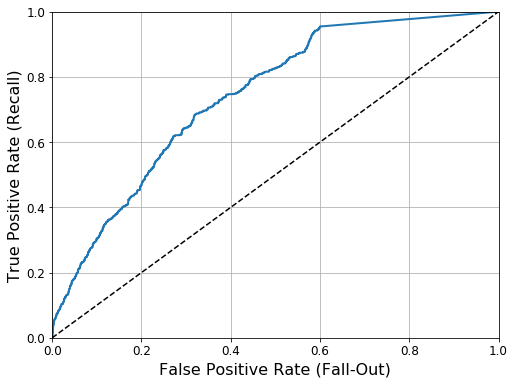

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

### Without white-list

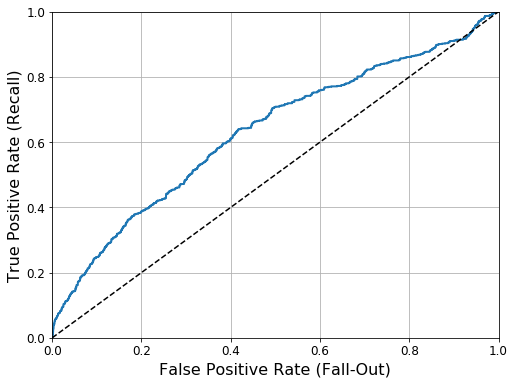

In [163]:
fpr, tpr, thresholds = roc_curve(y_statuses, test_pred[:, 1])
plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
plt.show()